# Loop 27 Analysis: Asymmetric vs Symmetric Solutions

## Goal
Identify which N values could benefit from asymmetric layouts by analyzing:
1. Current baseline structure (is it symmetric?)
2. Per-N efficiency gaps
3. Potential for asymmetric improvement

In [1]:
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
from shapely.affinity import rotate, translate
import matplotlib.pyplot as plt

TREE_TEMPLATE = [
    (0.0, 0.8), (0.125, 0.5), (0.0625, 0.5), (0.2, 0.25), (0.1, 0.25),
    (0.35, 0.0), (0.075, 0.0), (0.075, -0.2), (-0.075, -0.2), (-0.075, 0.0),
    (-0.35, 0.0), (-0.1, 0.25), (-0.2, 0.25), (-0.0625, 0.5), (-0.125, 0.5)
]

def parse_s_value(val):
    if isinstance(val, str) and val.startswith('s'):
        return float(val[1:])
    return float(val)

def create_tree_polygon(x, y, angle):
    tree = Polygon(TREE_TEMPLATE)
    tree = rotate(tree, angle, origin=(0, 0), use_radians=False)
    tree = translate(tree, x, y)
    return tree

def get_bounding_box_side(trees):
    all_x, all_y = [], []
    for tree in trees:
        minx, miny, maxx, maxy = tree.bounds
        all_x.extend([minx, maxx])
        all_y.extend([miny, maxy])
    return max(max(all_x) - min(all_x), max(all_y) - min(all_y))

# Load baseline
df = pd.read_csv('/home/submission/submission.csv')
df['x'] = df['x'].apply(parse_s_value)
df['y'] = df['y'].apply(parse_s_value)
df['deg'] = df['deg'].apply(parse_s_value)
df['n'] = df['id'].apply(lambda x: int(x.split('_')[0]))

print(f"Loaded {len(df)} rows")
print(f"N range: {df['n'].min()} to {df['n'].max()}")
print(f"\nFirst few rows:")
print(df.head(10))

Loaded 20100 rows
N range: 1 to 200

First few rows:
      id          x          y         deg  n
0  001_0  40.752901 -32.002949   45.000000  1
1  002_0   0.202513  -0.028958  203.629378  2
2  002_1  -0.105681  -0.551876   23.629378  2
3  003_0   1.127378   0.792211  112.222534  3
4  003_1   1.234056   1.276000   66.370622  3
5  003_2   0.641715   1.180459  155.134052  3
6  004_0  -0.324748   0.132110  156.370622  4
7  004_1   0.315354   0.132110  156.370622  4
8  004_2   0.324748  -0.732110  336.370622  4
9  004_3  -0.315354  -0.732110  336.370622  4


In [2]:
# Calculate per-N scores and analyze symmetry
results = []

for n in range(1, 201):
    group = df[df['n'] == n]
    trees = [create_tree_polygon(row['x'], row['y'], row['deg']) for _, row in group.iterrows()]
    side = get_bounding_box_side(trees)
    score = (side ** 2) / n
    
    # Analyze angles - are they symmetric?
    angles = group['deg'].values % 360  # Normalize to 0-360
    unique_angles = len(np.unique(np.round(angles, 1)))
    
    # Analyze positions - check for symmetry patterns
    xs = group['x'].values
    ys = group['y'].values
    
    # Check if positions are roughly symmetric around center
    cx, cy = np.mean(xs), np.mean(ys)
    xs_centered = xs - cx
    ys_centered = ys - cy
    
    # Check for rotational symmetry (180 degree)
    rot_sym_score = 0
    for i in range(len(xs_centered)):
        # Find if there's a point at (-x, -y)
        for j in range(len(xs_centered)):
            if i != j:
                if abs(xs_centered[i] + xs_centered[j]) < 0.1 and abs(ys_centered[i] + ys_centered[j]) < 0.1:
                    rot_sym_score += 1
                    break
    rot_sym_ratio = rot_sym_score / n if n > 1 else 1.0
    
    results.append({
        'n': n,
        'side': side,
        'score': score,
        'unique_angles': unique_angles,
        'rot_sym_ratio': rot_sym_ratio
    })

results_df = pd.DataFrame(results)
print("Per-N analysis:")
print(results_df.head(20))

Per-N analysis:
     n      side     score  unique_angles  rot_sym_ratio
0    1  0.813173  0.661250              1       1.000000
1    2  0.949504  0.450779              2       1.000000
2    3  1.142031  0.434745              3       0.000000
3    4  1.290806  0.416545              2       1.000000
4    5  1.443692  0.416850              5       0.800000
5    6  1.548438  0.399610              5       0.000000
6    7  1.673104  0.399897              7       0.571429
7    8  1.755921  0.385407              6       1.000000
8    9  1.867280  0.387415              9       0.000000
9   10  1.940696  0.376630             10       0.000000
10  11  2.030803  0.374924             11       0.000000
11  12  2.114873  0.372724             12       0.500000
12  13  2.199960  0.372294             13       0.461538
13  14  2.274555  0.369543             12       1.000000
14  15  2.377866  0.376950             13       0.266667
15  16  2.446640  0.374128              4       1.000000
16  17  2.50812

In [3]:
# Calculate theoretical lower bounds and efficiency
# For a single tree, the minimum bounding box is achieved at 45 degrees
# Tree area is approximately 0.2625 (calculated from polygon)

tree_area = Polygon(TREE_TEMPLATE).area
print(f"Single tree area: {tree_area:.6f}")

# Theoretical minimum: if we could pack trees with 100% efficiency
# score = (sqrt(n * tree_area))^2 / n = tree_area
# But trees have irregular shape, so efficiency is always < 100%

results_df['theoretical_min'] = tree_area  # If 100% packing efficiency
results_df['efficiency'] = tree_area / results_df['score'] * 100

print("\nEfficiency analysis:")
print(results_df[['n', 'score', 'efficiency', 'rot_sym_ratio']].describe())

Single tree area: 0.245625

Efficiency analysis:
                n       score  efficiency  rot_sym_ratio
count  200.000000  200.000000  200.000000     200.000000
mean   100.500000    0.353130   69.858050       0.398566
std     57.879185    0.028097    3.954926       0.387768
min      1.000000    0.329945   37.145558       0.000000
25%     50.750000    0.340034   68.080580       0.056151
50%    100.500000    0.346907   70.804254       0.211324
75%    150.250000    0.360786   72.235518       0.813214
max    200.000000    0.661250   74.444313       1.000000


In [4]:
# Identify N values with lowest efficiency (most room for improvement)
print("\nN values with LOWEST efficiency (most room for improvement):")
lowest_eff = results_df.nsmallest(20, 'efficiency')
print(lowest_eff[['n', 'score', 'efficiency', 'unique_angles', 'rot_sym_ratio']])


N values with LOWEST efficiency (most room for improvement):
     n     score  efficiency  unique_angles  rot_sym_ratio
0    1  0.661250   37.145558              1       1.000000
1    2  0.450779   54.488985              2       1.000000
2    3  0.434745   56.498619              3       0.000000
4    5  0.416850   58.924131              5       0.800000
3    4  0.416545   58.967240              2       1.000000
6    7  0.399897   61.422135              7       0.571429
5    6  0.399610   61.466135              5       0.000000
8    9  0.387415   63.400999              9       0.000000
7    8  0.385407   63.731287              6       1.000000
14  15  0.376950   65.161191             13       0.266667
9   10  0.376630   65.216518             10       0.000000
20  21  0.376451   65.247553             20       0.190476
19  20  0.376057   65.315921             20       0.300000
21  22  0.375258   65.454949             21       0.000000
10  11  0.374924   65.513326             11       0.0

In [5]:
# Identify N values with highest efficiency (likely already optimal)
print("\nN values with HIGHEST efficiency (likely optimal):")
highest_eff = results_df.nlargest(20, 'efficiency')
print(highest_eff[['n', 'score', 'efficiency', 'unique_angles', 'rot_sym_ratio']])


N values with HIGHEST efficiency (likely optimal):
       n     score  efficiency  unique_angles  rot_sym_ratio
180  181  0.329945   74.444313             26       0.066298
155  156  0.329986   74.435021             23       1.000000
181  182  0.329988   74.434616             24       0.000000
179  180  0.331000   74.206879             27       0.044444
154  155  0.332069   73.968128             27       0.993548
167  168  0.332475   73.877813              4       1.000000
194  195  0.332576   73.855314             51       0.010256
178  179  0.332595   73.851150             35       0.067039
166  167  0.332835   73.797918             21       0.958084
193  194  0.332999   73.761528             52       0.000000
195  196  0.333261   73.703404             58       0.030612
192  193  0.333339   73.686144             66       0.020725
131  132  0.333799   73.584705             29       0.015152
153  154  0.334158   73.505715             27       0.987013
177  178  0.334442   73.443314   

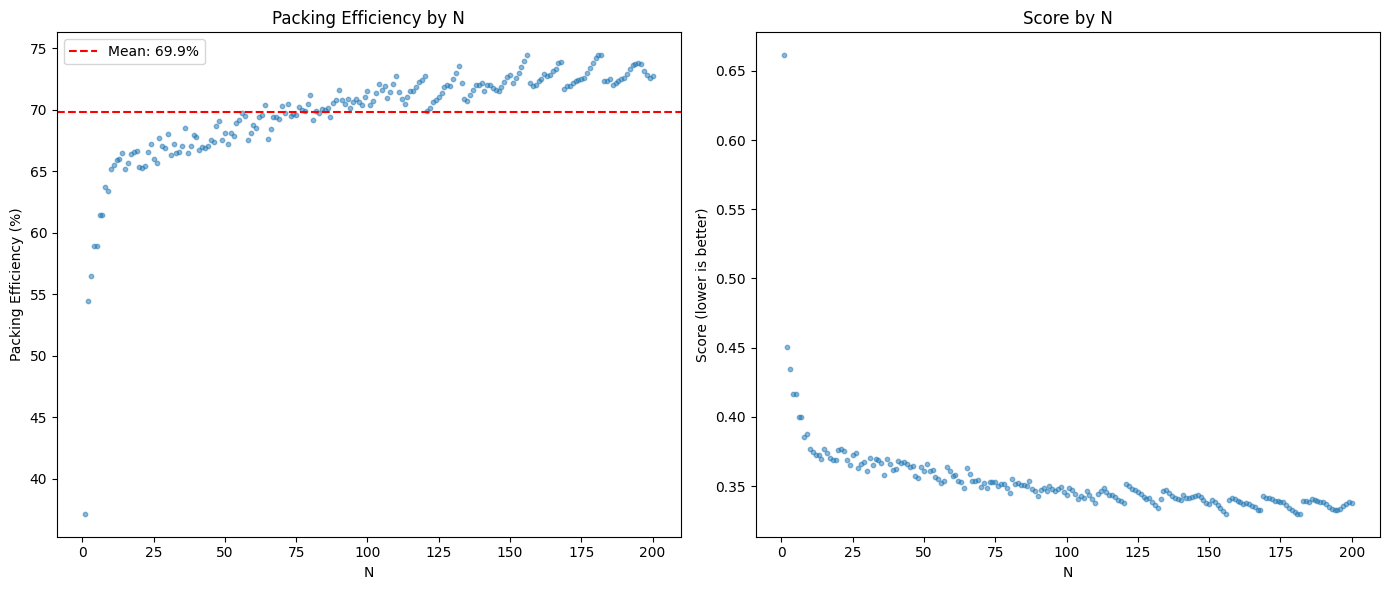

In [6]:
# Plot efficiency by N
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(results_df['n'], results_df['efficiency'], alpha=0.5, s=10)
plt.xlabel('N')
plt.ylabel('Packing Efficiency (%)')
plt.title('Packing Efficiency by N')
plt.axhline(y=results_df['efficiency'].mean(), color='r', linestyle='--', label=f'Mean: {results_df["efficiency"].mean():.1f}%')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(results_df['n'], results_df['score'], alpha=0.5, s=10)
plt.xlabel('N')
plt.ylabel('Score (lower is better)')
plt.title('Score by N')
plt.tight_layout()
plt.savefig('/home/code/exploration/loop27_efficiency.png', dpi=100)
plt.show()

In [7]:
# Analyze which N values contribute most to total score
results_df['contribution'] = results_df['score']
results_df['cumulative_contribution'] = results_df['contribution'].cumsum()
results_df['pct_contribution'] = results_df['contribution'] / results_df['contribution'].sum() * 100

print("\nScore contribution by N range:")
for start, end in [(1, 10), (11, 50), (51, 100), (101, 150), (151, 200)]:
    subset = results_df[(results_df['n'] >= start) & (results_df['n'] <= end)]
    total = subset['score'].sum()
    pct = total / results_df['score'].sum() * 100
    avg_eff = subset['efficiency'].mean()
    print(f"N={start:3d}-{end:3d}: Score={total:.4f} ({pct:.1f}%), Avg Efficiency={avg_eff:.1f}%")

print(f"\nTotal score: {results_df['score'].sum():.6f}")
print(f"Target: 68.919154")
print(f"Gap: {results_df['score'].sum() - 68.919154:.6f}")


Score contribution by N range:
N=  1- 10: Score=4.3291 (6.1%), Avg Efficiency=58.1%
N= 11- 50: Score=14.7042 (20.8%), Avg Efficiency=66.8%
N= 51-100: Score=17.6134 (24.9%), Avg Efficiency=69.7%
N=101-150: Score=17.1363 (24.3%), Avg Efficiency=71.7%
N=151-200: Score=16.8430 (23.8%), Avg Efficiency=72.9%

Total score: 70.625918
Target: 68.919154
Gap: 1.706764


In [8]:
# Key insight: Which N values have the most potential for improvement?
# Look at N values where:
# 1. Efficiency is low (room for improvement)
# 2. Score contribution is high (impact on total)

results_df['improvement_potential'] = results_df['contribution'] * (100 - results_df['efficiency']) / 100

print("\nN values with HIGHEST improvement potential (low efficiency + high contribution):")
top_potential = results_df.nlargest(20, 'improvement_potential')
print(top_potential[['n', 'score', 'efficiency', 'improvement_potential']])


N values with HIGHEST improvement potential (low efficiency + high contribution):
     n     score  efficiency  improvement_potential
0    1  0.661250   37.145558               0.415625
1    2  0.450779   54.488985               0.205154
2    3  0.434745   56.498619               0.189120
4    5  0.416850   58.924131               0.171225
3    4  0.416545   58.967240               0.170920
6    7  0.399897   61.422135               0.154272
5    6  0.399610   61.466135               0.153985
8    9  0.387415   63.400999               0.141790
7    8  0.385407   63.731287               0.139782
14  15  0.376950   65.161191               0.131325
9   10  0.376630   65.216518               0.131005
20  21  0.376451   65.247553               0.130826
19  20  0.376057   65.315921               0.130432
21  22  0.375258   65.454949               0.129633
10  11  0.374924   65.513326               0.129299
15  16  0.374128   65.652665               0.128503
25  26  0.373997   65.675668     

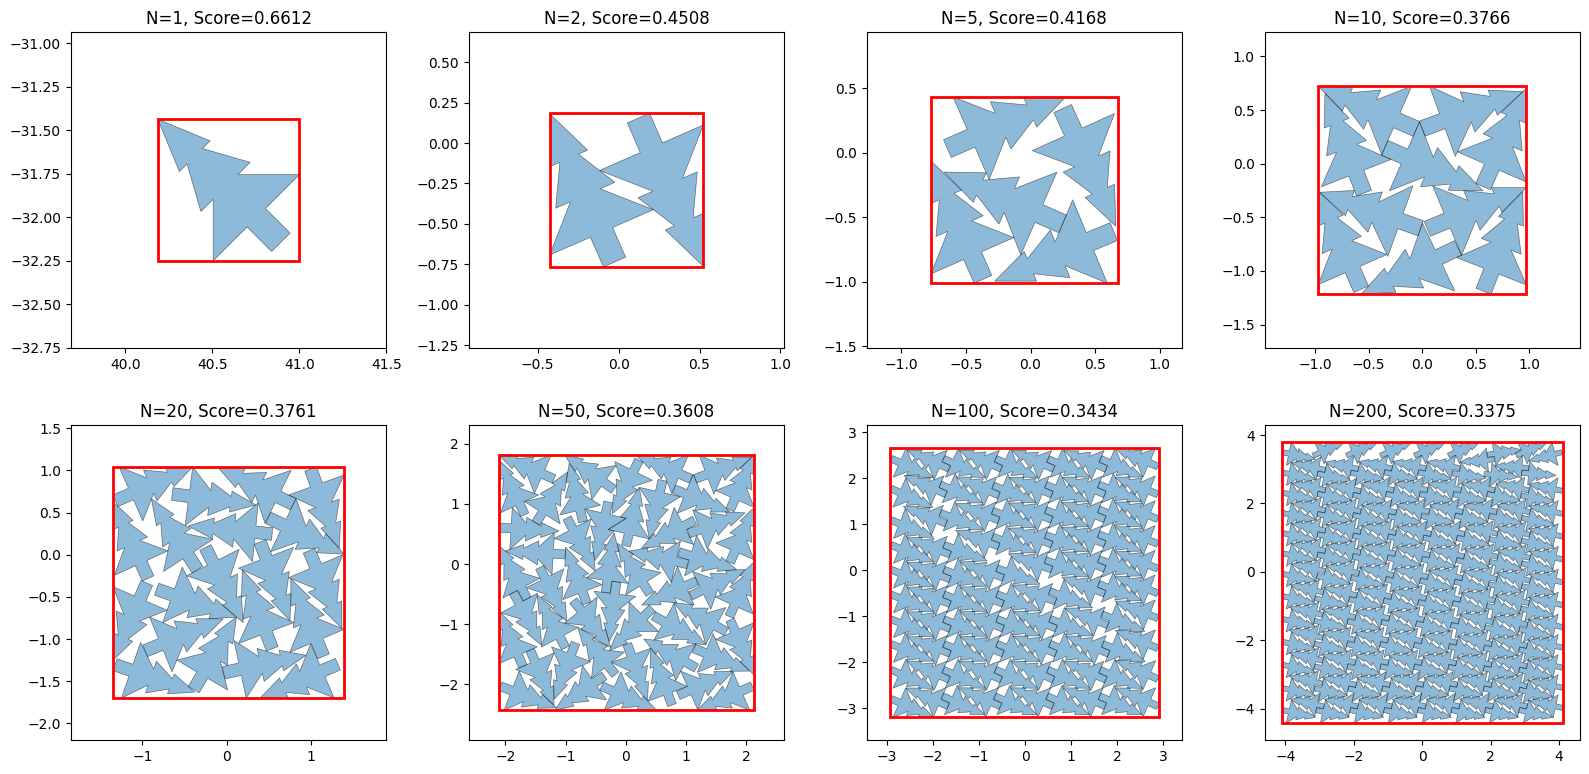

In [9]:
# Visualize the baseline solution for a few key N values
import matplotlib.patches as patches
from matplotlib.patches import Polygon as MplPolygon

def visualize_solution(n, ax):
    group = df[df['n'] == n]
    trees = [create_tree_polygon(row['x'], row['y'], row['deg']) for _, row in group.iterrows()]
    
    # Get bounding box
    all_x, all_y = [], []
    for tree in trees:
        minx, miny, maxx, maxy = tree.bounds
        all_x.extend([minx, maxx])
        all_y.extend([miny, maxy])
    
    min_x, max_x = min(all_x), max(all_x)
    min_y, max_y = min(all_y), max(all_y)
    side = max(max_x - min_x, max_y - min_y)
    
    # Draw trees
    for i, tree in enumerate(trees):
        coords = list(tree.exterior.coords)
        poly = MplPolygon(coords, fill=True, alpha=0.5, edgecolor='black', linewidth=0.5)
        ax.add_patch(poly)
    
    # Draw bounding box
    cx = (min_x + max_x) / 2
    cy = (min_y + max_y) / 2
    rect = patches.Rectangle((cx - side/2, cy - side/2), side, side, 
                               fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    
    ax.set_xlim(cx - side/2 - 0.5, cx + side/2 + 0.5)
    ax.set_ylim(cy - side/2 - 0.5, cy + side/2 + 0.5)
    ax.set_aspect('equal')
    ax.set_title(f'N={n}, Score={results_df[results_df["n"]==n]["score"].values[0]:.4f}')

# Visualize some key N values
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
n_values = [1, 2, 5, 10, 20, 50, 100, 200]
for ax, n in zip(axes.flat, n_values):
    visualize_solution(n, ax)
plt.tight_layout()
plt.savefig('/home/code/exploration/loop27_solutions.png', dpi=100)
plt.show()

In [10]:
# Summary and recommendations
print("="*70)
print("LOOP 27 ANALYSIS SUMMARY")
print("="*70)

print(f"\nCurrent total score: {results_df['score'].sum():.6f}")
print(f"Target: 68.919154")
print(f"Gap to close: {results_df['score'].sum() - 68.919154:.6f} ({(results_df['score'].sum() - 68.919154) / 68.919154 * 100:.2f}%)")

print("\n" + "="*70)
print("KEY FINDINGS:")
print("="*70)

# Find N values with lowest efficiency
low_eff = results_df[results_df['efficiency'] < 60]
print(f"\n1. N values with efficiency < 60%: {len(low_eff)}")
if len(low_eff) > 0:
    print(f"   These are: {sorted(low_eff['n'].tolist())}")

# Find N values with high contribution but low efficiency
high_impact = results_df[(results_df['efficiency'] < 70) & (results_df['score'] > 0.35)]
print(f"\n2. High-impact N values (score > 0.35, efficiency < 70%): {len(high_impact)}")
if len(high_impact) > 0:
    print(f"   These are: {sorted(high_impact['n'].tolist())}")

print("\n" + "="*70)
print("RECOMMENDATIONS:")
print("="*70)
print("\n1. Focus on N values with LOWEST efficiency - these have most room for improvement")
print("2. Try ASYMMETRIC layouts for these N values - break the symmetry")
print("3. Use GREEDY EDGE FILLING after initial placement")
print("4. Test on small N first (N=1-10) before scaling")

LOOP 27 ANALYSIS SUMMARY

Current total score: 70.625918
Target: 68.919154
Gap to close: 1.706764 (2.48%)

KEY FINDINGS:

1. N values with efficiency < 60%: 5
   These are: [1, 2, 3, 4, 5]

2. High-impact N values (score > 0.35, efficiency < 70%): 79
   These are: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 71, 73, 74, 75, 77, 78, 81, 82, 83, 87, 121]

RECOMMENDATIONS:

1. Focus on N values with LOWEST efficiency - these have most room for improvement
2. Try ASYMMETRIC layouts for these N values - break the symmetry
3. Use GREEDY EDGE FILLING after initial placement
4. Test on small N first (N=1-10) before scaling
